# Plug-and-Play priors

**Author: M. Ravasi, KAUST**

Welcome to the sixt exercise of the **An introduction to proximal solvers for engineers** course!

The aim of this tutorial is to:

- Learn how to use denoisers in spite of proximable functions in proximal solvers;
- Understand how to run any of PyProximal's solver with a PnP prior.

Let's first import the libraries we need in this tutorial

In [1]:
# Run this when using Colab (will install the missing libraries)
# !pip install pylops pyproximal

In [2]:
%load_ext autoreload
%autoreload 2
# %matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pylops
import pyproximal

from scipy.io import loadmat
from skimage.restoration import denoise_nl_means, estimate_sigma
from pylops.config import set_ndarray_multiplication

np.random.seed(0)
set_ndarray_multiplication(False)

In [3]:
def callback(x, xtrue, xhist, errhist):
    xhist.append(x)
    errhist.append(np.linalg.norm(x - xtrue))

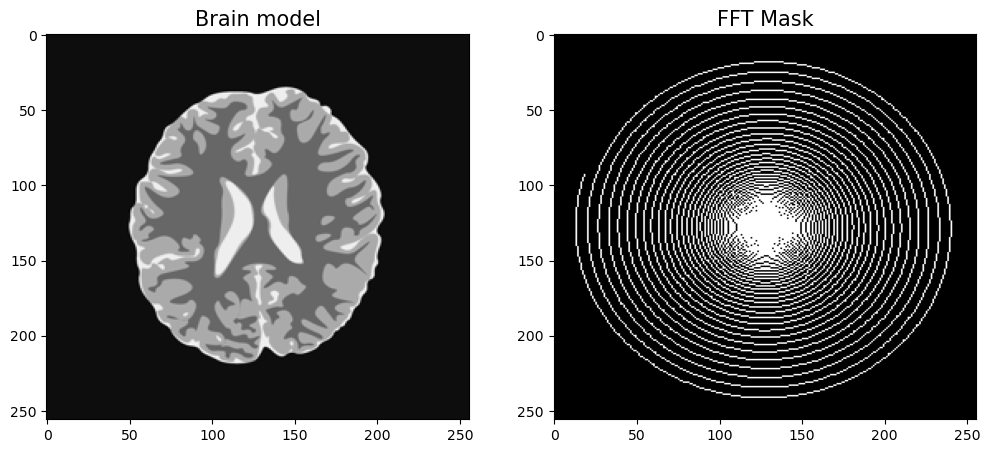

In [4]:
x = loadmat('../data/brainphantom.mat')
mask = loadmat('../data/spiralsampling.mat')

x = x['gt']
x = x / x.max()
mask = mask['samp']
mask_fft = np.fft.ifftshift(mask)
ny, nx = x.shape

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(x, cmap='gray')
ax[0].axis('tight')
ax[0].set_title('Brain model', fontsize=15)
ax[1].imshow(mask, cmap='gray')
ax[1].set_title('FFT Mask', fontsize=15)
ax[1].axis('tight');

# Reconstruction operator
Fop = pylops.signalprocessing.FFT2D(dims=x.shape)
Rop = pylops.Restriction(x.size, np.where(mask_fft.ravel() == 1)[0], forceflat=True, dtype=np.complex128)
Op = Rop * Fop

# Data (optionally adding some noise)
sigman = 0.
x_fft = Fop * x.ravel()
x_fft = x_fft.reshape(x.shape)
y = Op * x.ravel()
y += np.random.normal(0, sigman, y.shape)

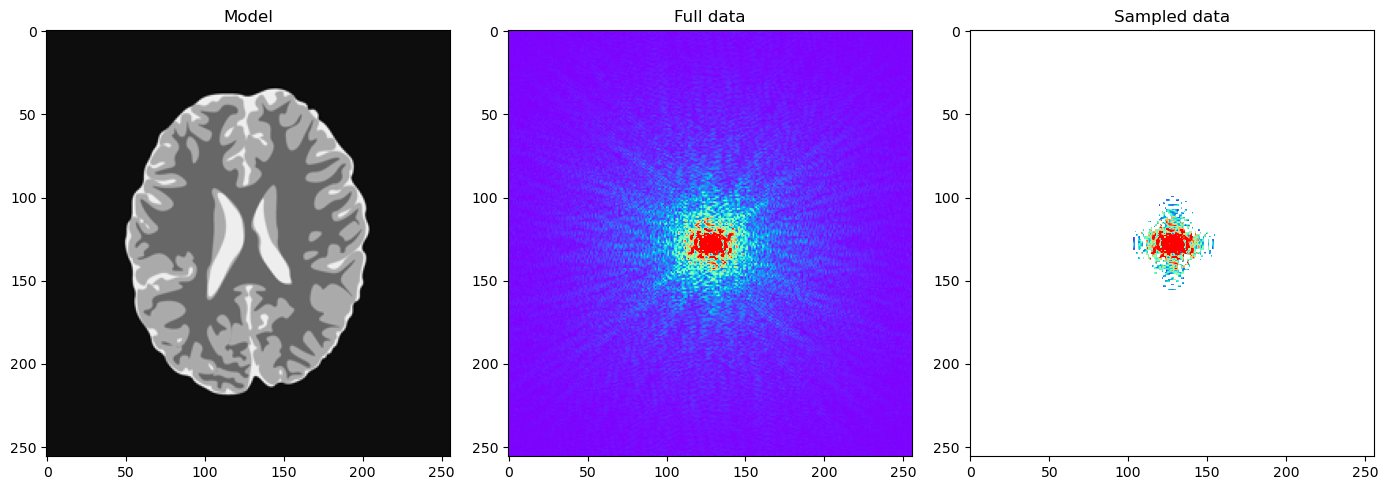

In [5]:
###############################################################################
# We now create and display the data alongside the model
y = Rop * Fop * x.ravel()
yfft = Fop * x.ravel()
yfft = np.fft.fftshift(yfft.reshape(ny, nx))

ymask = Rop.mask(Fop * x.ravel())
ymask = ymask.reshape(ny, nx)
ymask.data[:] = np.fft.fftshift(ymask.data)
ymask.mask[:] = np.fft.fftshift(ymask.mask)

fig, axs = plt.subplots(1, 3, figsize=(14, 5))
axs[0].imshow(x, vmin=0, vmax=1, cmap="gray")
axs[0].set_title("Model")
axs[0].axis("tight")
axs[1].imshow(np.abs(yfft), vmin=0, vmax=1, cmap="rainbow")
axs[1].set_title("Full data")
axs[1].axis("tight")
axs[2].imshow(np.abs(ymask), vmin=0, vmax=1, cmap="rainbow")
axs[2].set_title("Sampled data")
axs[2].axis("tight")
plt.tight_layout()

In [6]:
# Operator and step sizes
Op = Rop * Fop
L = np.real((Op.H*Op).eigs(neigs=1, which='LM')[0])
tau = 1./L
sigma = 0.05

# L2 proximal
l2 = pyproximal.proximal.L2(Op=Op, b=y.ravel(), niter=50, warm=True)

# NLM denoiser
denoiser = lambda x, tau: denoise_nl_means(np.real(x), patch_distance=15, h=.05) #, sigma=1)

In [7]:
# PG-Pnp
xhistpg, errhistpg = [], []
xpnppg = pyproximal.optimization.pnp.PlugAndPlay(l2, denoiser, x.shape,
                                                 solver=pyproximal.optimization.primal.ProximalGradient,
                                                 tau=tau, x0=np.zeros(x.size),
                                                 niter=10,
                                                 acceleration='fista',
                                                 show=True,
                                                 callback=lambda xx: callback(xx, x.ravel(), 
                                                                              xhistpg,
                                                                              errhistpg))
xpnppg = np.real(xpnppg.reshape(x.shape))

Accelerated Proximal Gradient
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.optimization.pnp._Denoise'>
tau = 0.9999999999999993	backtrack = False	beta = 5.000000e-01
epsg = 1.0	niter = 10	tol = None
niterback = 100	acceleration = fista

   Itn       x[0]          f           g       J=f+eps*g       tau
     1   4.95735e-02   3.053e+01   0.000e+00   3.053e+01   1.000e+00
     2   5.30672e-02   1.720e+01   0.000e+00   1.720e+01   1.000e+00
     3   5.42051e-02   1.170e+01   0.000e+00   1.170e+01   1.000e+00
     4   5.43397e-02   9.517e+00   0.000e+00   9.517e+00   1.000e+00
     5   5.43086e-02   8.638e+00   0.000e+00   8.638e+00   1.000e+00
     6   5.42727e-02   8.278e+00   0.000e+00   8.278e+00   1.000e+00
     7   5.42483e-02   8.128e+00   0.000e+00   8.128e+00   1.000e+00
     8   5.42302e-02   8.063e+00   0.000e+00   8.063e+00   1.000e+00
     9   5.42175e-02   8.031e+

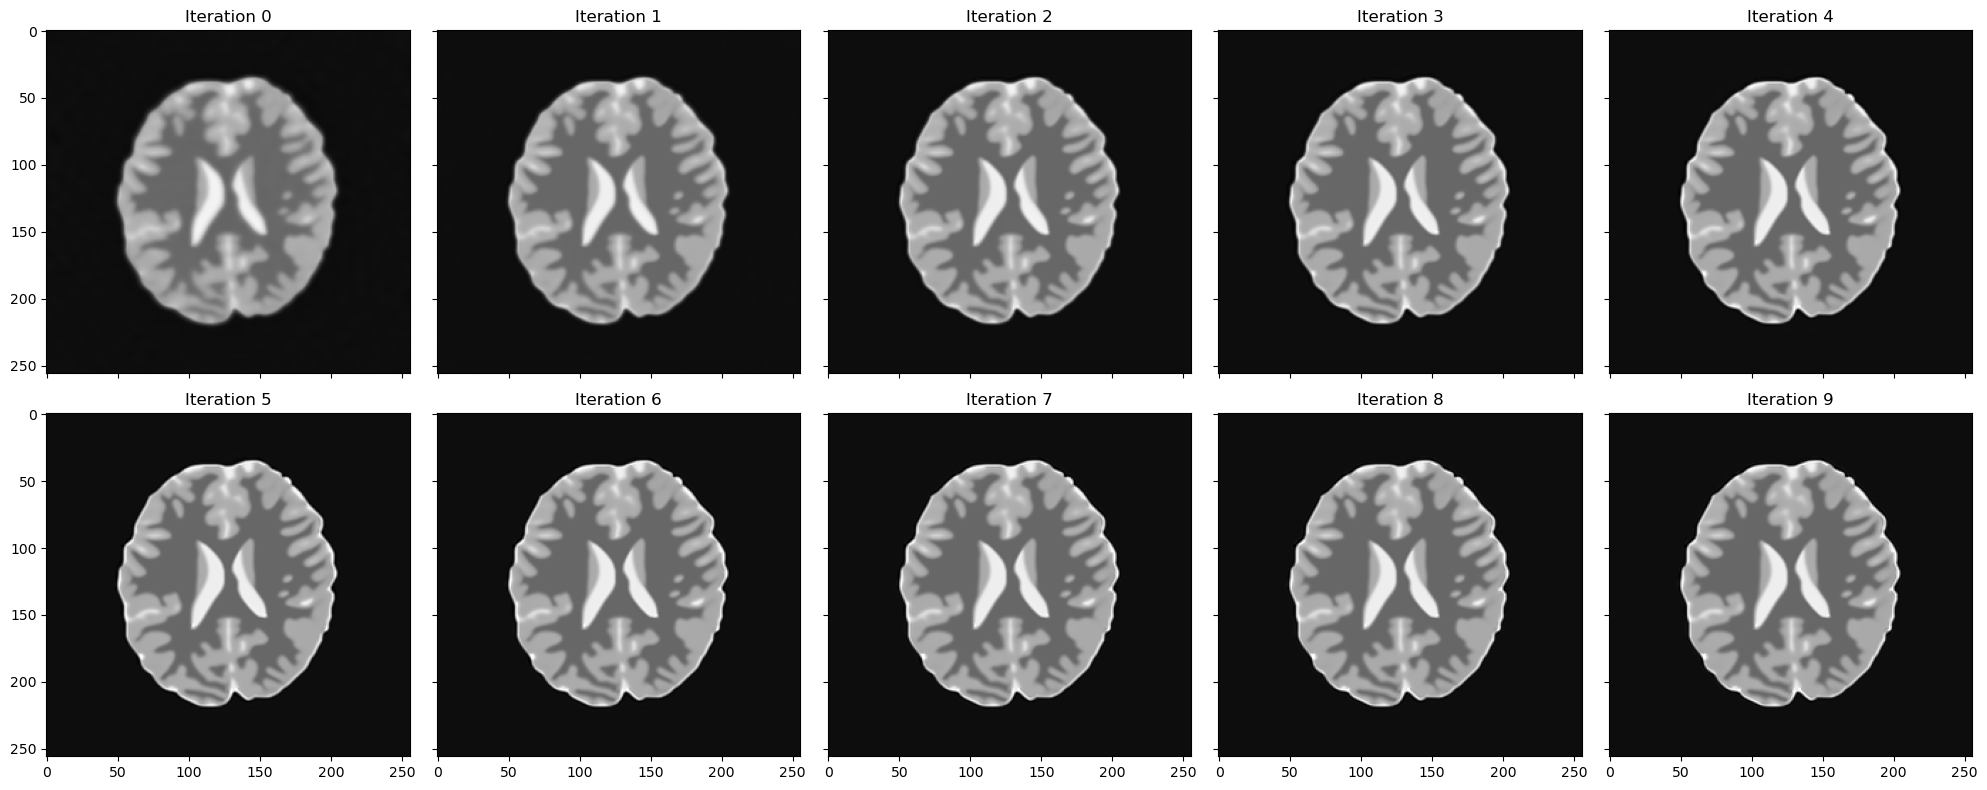

In [8]:
fig, axs = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(20, 8))
axs = axs.ravel()

for i in range(10):
    axs[i].imshow(np.real(xhistpg[i]).reshape(x.shape), vmin=0, vmax=1, cmap="gray")
    axs[i].set_title('Iteration %d' %i)
    axs[i].axis('tight')
fig.tight_layout()

In [9]:
# ADMM-PnP
xhistadmm, errhistadmm = [], []
xpnpadmm = pyproximal.optimization.pnp.PlugAndPlay(l2, denoiser, x.shape,
                                                   solver=pyproximal.optimization.primal.ADMM,
                                                   tau=tau, x0=np.zeros(x.size),
                                                   niter=10, show=True,
                                                   callback=lambda xx: callback(xx, x.ravel(),
                                                                                xhistadmm, errhistadmm))[0]
xpnpadmm = np.real(xpnpadmm.reshape(x.shape))

ADMM
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.optimization.pnp._Denoise'>
tau = 1.000000e+00	niter = 10

   Itn       x[0]          f           g       J = f + g
     1   2.32186e-02   9.821e+02   0.000e+00   9.821e+02
     2   3.47346e-02   2.861e+02   0.000e+00   2.861e+02
     3   4.69611e-02   9.073e+01   0.000e+00   9.073e+01
     4   5.08585e-02   3.597e+01   0.000e+00   3.597e+01
     5   5.26787e-02   1.932e+01   0.000e+00   1.932e+01
     6   5.34817e-02   1.354e+01   0.000e+00   1.354e+01
     7   5.39836e-02   1.116e+01   0.000e+00   1.116e+01
     8   5.42161e-02   9.998e+00   0.000e+00   9.998e+00
     9   5.43347e-02   9.353e+00   0.000e+00   9.353e+00
    10   5.43952e-02   8.960e+00   0.000e+00   8.960e+00

Total time (s) = 2.52
---------------------------------------------------------



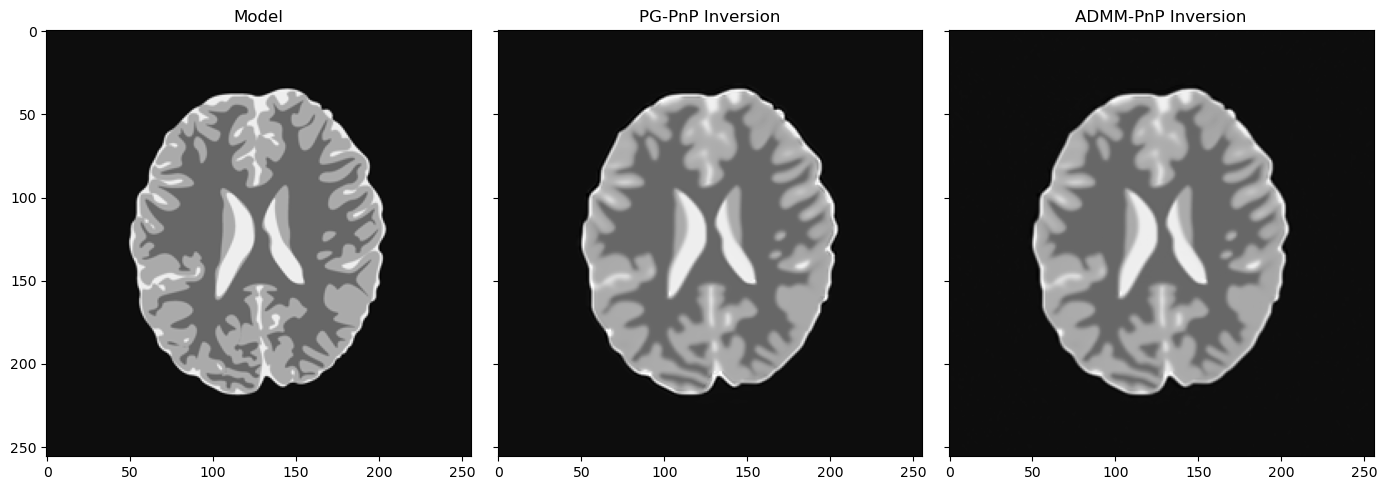

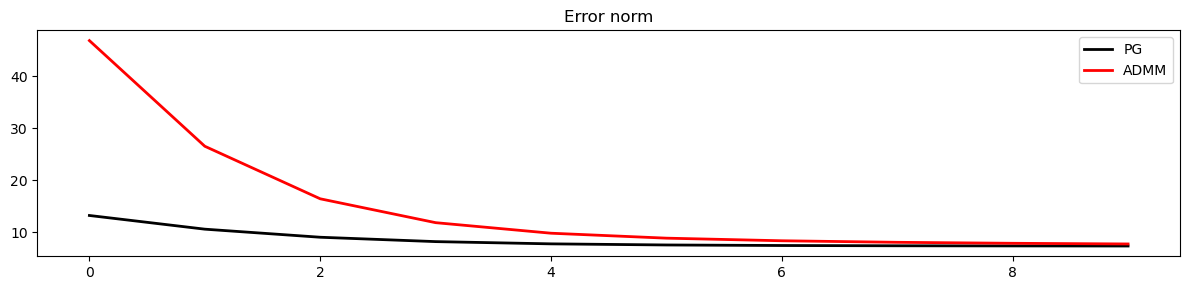

In [10]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(14, 5))
axs[0].imshow(x, vmin=0, vmax=1, cmap="gray")
axs[0].set_title("Model")
axs[0].axis("tight")
axs[1].imshow(xpnppg, vmin=0, vmax=1, cmap="gray")
axs[1].set_title("PG-PnP Inversion")
axs[1].axis("tight")
axs[2].imshow(xpnpadmm, vmin=0, vmax=1, cmap="gray")
axs[2].set_title("ADMM-PnP Inversion")
axs[2].axis("tight")
plt.tight_layout()

plt.figure(figsize=(12, 3))
plt.plot(errhistpg, 'k', lw=2, label='PG')
plt.plot(errhistadmm, 'r', lw=2, label='ADMM')
plt.title("Error norm")
plt.legend()
plt.tight_layout()

## Recap

In this tutorial we have learned to:

- How to use the non-local means denoising algorithm in scikit-image as a PnP prior;
- How to include PnP priors in PyProximal.